In [125]:
import pandas as pd

# train: contains gold labels and input text
# test: only contains input text
# hw1_labels_dev.txt is actually just the label for train data, which is useless(not sure why it is provided)

DATA_PATH = {
    "train": "data/hw1_train.xlsx",
    "test": "data/hw1_test.xlsx",
}

train_df = pd.read_excel(DATA_PATH["train"])
test_df = pd.read_excel(DATA_PATH["test"])

In [127]:
# fix typo: I-movie => I_movie
train_df["IOB Slot tags"] = train_df["IOB Slot tags"].apply(
    lambda tags: tags.replace("I-movie", "I_movie")
)

In [188]:
# number of data examples for train/test
train_num = len(train_df)
test_num = len(test_df)
intent_train_num = len(train_df["Core Relations"].dropna())
slot_train_num = len(train_df["IOB Slot tags"].dropna())
print("Number of Data Examples")
print("Train:", train_num)
print("Test:", test_num)
print("Number of Intent Data Examples")
print("Train:", intent_train_num)
print("Number of Slot Data Examples")
print("Train:", slot_train_num)

Number of Data Examples
Train: 2253
Test: 981
Number of Intent Data Examples
Train: 1941
Number of Slot Data Examples
Train: 2253


In [129]:
# sequence length
#     min
#     max
#     average

# tokenize with splitting by space
def tokenize(utterance):
    return utterance.split()


train_df["tokens"] = train_df["utterances"].apply(tokenize)
test_df["tokens"] = test_df["utterances"].apply(tokenize)

train_lens = train_df["tokens"].apply(len)
test_lens = test_df["tokens"].apply(len)

print("SeqLen: Min, Avg, Max")
print("Train:", train_lens.min(), train_lens.mean(), train_lens.max())
print("Test:", test_lens.min(), test_lens.mean(), test_lens.max())

SeqLen: Min, Avg, Max
Train: 1 6.292498890368398 21
Test: 1 6.539245667686035 22


<AxesSubplot:ylabel='Frequency'>

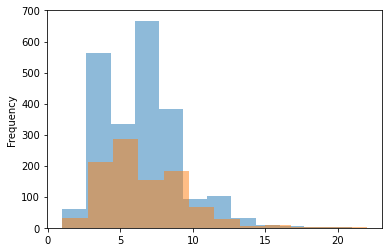

In [130]:
train_lens.plot.hist(bins=12, alpha=0.5)
test_lens.plot.hist(bins=12, alpha=0.5)

In [164]:
# intent labels type/count
from collections import Counter, OrderedDict

relation_counter = Counter()

multi_relation_counts = []

for relation_str in train_df["Core Relations"].dropna():
    relations = relation_str.split()
    relation_counter.update(relations)

    # counting the mutliple labels number
    multi_relation_counts.append(len(relations))

relation_counter = OrderedDict(relation_counter.most_common())
"Intent Label Stat: ", relation_counter

('Intent Label Stat: ',
 OrderedDict([('movie.starring.actor', 340),
              ('movie.directed_by', 335),
              ('movie.country', 222),
              ('movie.language', 218),
              ('movie.rating', 208),
              ('movie.initial_release_date', 180),
              ('movie.produced_by', 173),
              ('movie.genre', 128),
              ('movie.subjects', 94),
              ('movie.production_companies', 93),
              ('movie.estimated_budget', 68),
              ('movie.gross_revenue', 31),
              ('movie.starring.character', 22),
              ('actor.gender', 8),
              ('gr.amount', 5),
              ('person.date_of_birth', 4),
              ('movie.music', 3),
              ('movie.locations', 3)]))

<BarContainer object of 18 artists>

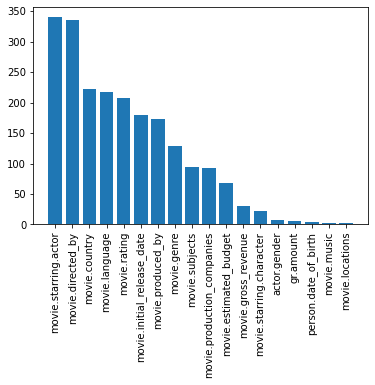

In [165]:
import matplotlib.pyplot as plt

plt.xticks(rotation="vertical")
plt.bar(relation_counter.keys(), relation_counter.values())

OrderedDict([(1, 1754), (2, 181), (3, 5), (4, 1)])


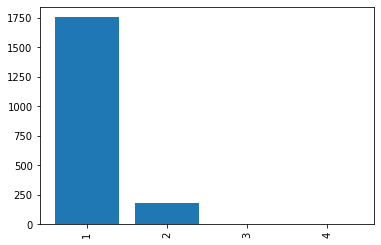

In [166]:
# intent multi-label count
multi_relation_counter = OrderedDict(Counter(multi_relation_counts).most_common())
plt.xticks(rotation="vertical")
plt.bar(
    [str(k) for k in multi_relation_counter.keys()], multi_relation_counter.values()
)
print(multi_relation_counter)

In [167]:
# NE slot type/count

slot_counter = Counter()

for slot_str in train_df["IOB Slot tags"].dropna():
    slots = slot_str.split()
    slot_counter.update(slots)

slot_counter = OrderedDict(slot_counter.most_common())
"Slot Label Stat: ", slot_counter

('Slot Label Stat: ',
 OrderedDict([('O', 10243),
              ('I_movie', 1094),
              ('B_movie', 981),
              ('B_director', 180),
              ('B_person', 177),
              ('I_person', 166),
              ('B_producer', 164),
              ('I_director', 163),
              ('B_country', 153),
              ('B_mpaa_rating', 140),
              ('B_language', 119),
              ('I_producer', 114),
              ('B_cast', 105),
              ('I_cast', 104),
              ('B_subject', 95),
              ('B_genre', 71),
              ('I_subject', 33),
              ('I_language', 17),
              ('B_char', 15),
              ('I_country', 12),
              ('I_mpaa_rating', 12),
              ('I_char', 5),
              ('I_genre', 5),
              ('B_release_year', 4),
              ('I_release_year', 3),
              ('B_location', 2)]))

In [168]:
# vocab size for train
least_freq = 0

train_vocab = Counter([token for tokens in train_df["tokens"] for token in tokens])
test_vocab = Counter([token for tokens in test_df["tokens"] for token in tokens])

train_vocab = OrderedDict(
    [(k, v) for k, v in train_vocab.most_common() if v > least_freq]
)
test_vocab = OrderedDict(
    [(k, v) for k, v in test_vocab.most_common() if v > least_freq]
)


print("Vocab Size")
print("Train: ", len(train_vocab))
print("Test: ", len(test_vocab))

Vocab Size
Train:  1147
Test:  934


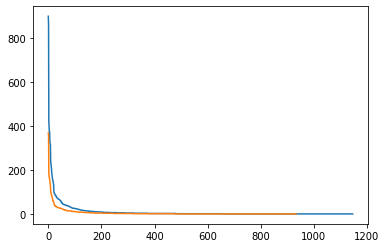

In [169]:
plt.plot(train_vocab.values())
plt.plot(test_vocab.values())

In [207]:
# splitting data and print the amount of train and dev split
# Intent Detection
def split_train_val_intent(df):
    train_intent_df = (
        df[["utterances", "Core Relations"]].copy().dropna(subset=["Core Relations"])
    )
    val_intent_df = train_intent_df.sample(0)
    for intent in train_intent_df["Core Relations"].unique():
        intent_idx = train_intent_df["Core Relations"] == intent
        intent_size = len(train_intent_df[intent_idx])
        val_intent_size = int(intent_size * 0.3)
        train_intent_size = intent_size - val_intent_size
        val_intent_df = pd.concat(
            [val_intent_df, train_intent_df[intent_idx].sample(val_intent_size)]
        )
    train_intent_df = train_intent_df.drop(val_intent_df.index)
    return train_intent_df, val_intent_df


train_intent_df, val_intent_df = split_train_val_intent(train_df)

print("Intent train set split amount:")
print(len(train_intent_df), len(val_intent_df))

Intent train set split amount:
1378 563


In [208]:
# Slot Tagging
def split_train_val_slot(df):
    train_slot_df = (
        df[["utterances", "IOB Slot tags"]].copy().dropna(subset=["IOB Slot tags"])
    )
    train_slot_df["slot_set"] = train_slot_df["IOB Slot tags"].apply(
        lambda slot_text: " ".join(sorted(list(set(slot_text.split()))))
    )
    val_slot_df = train_slot_df.sample(0)
    for slot_set_type in train_slot_df["slot_set"].unique():
        slot_idx = train_slot_df["slot_set"] == slot_set_type
        slot_size = len(train_slot_df[slot_idx])
        val_slot_size = int(slot_size * 0.3)
        train_slot_size = slot_size - val_slot_size
        val_slot_df = pd.concat(
            [val_slot_df, train_slot_df[slot_idx].sample(val_slot_size)]
        )
    train_slot_df = train_slot_df.drop(val_slot_df.index)
    return train_slot_df, val_slot_df


train_slot_df, val_slot_df = split_train_val_slot(train_df)

print("Slot train set split amount:")
print(len(train_slot_df), len(val_slot_df))

Slot train set split amount:
1602 651


In [240]:
def build_counter(df, key):
    counter = Counter()
    if key == "Core Relations":
        for label in df[key].dropna():
            labels = label.split()
            counter.update(labels)
    else:
        counter = Counter(df[key])
    return OrderedDict(counter.most_common())

In [253]:
# sampling and augment the data for solving label imbalance issue
# Intent Detection


def balance_intent_data(df):
    relation_counter = build_counter(df, "Core Relations")

    avg_count = int(sum(relation_counter.values()) / len(relation_counter.values()))
    sample_df = df.sample(0)

    for k, v in relation_counter.items():
        if v >= avg_count:
            continue
        # to be sample amount
        sample_count = avg_count - v

        idx_of_label_k = df["Core Relations"].apply(lambda label: k in label)

        # if sample amount if larger, then sample all the value until it exceed the sample count
        while sample_count > relation_counter[k]:
            temp_df = df[idx_of_label_k].sample(relation_counter[k])
            sample_df = pd.concat([sample_df, temp_df])
            sample_count -= relation_counter[k]

        sample_df = pd.concat([sample_df, df[idx_of_label_k].sample(sample_count)])
    balance_df = pd.concat([df.copy(), sample_df])

    return balance_df


relation_df = train_intent_df[["utterances", "Core Relations"]].dropna()
balance_relation_df = balance_intent_data(relation_df)

In [254]:
build_counter(balance_relation_df, "Core Relations")

OrderedDict([('movie.starring.actor', 374),
             ('movie.directed_by', 265),
             ('movie.country', 186),
             ('movie.gross_revenue', 164),
             ('movie.language', 155),
             ('movie.rating', 149),
             ('movie.initial_release_date', 132),
             ('movie.produced_by', 122),
             ('movie.genre', 98),
             ('gr.amount', 96),
             ('movie.starring.character', 84),
             ('actor.gender', 84),
             ('person.date_of_birth', 84),
             ('movie.estimated_budget', 84),
             ('movie.music', 84),
             ('movie.locations', 84),
             ('movie.production_companies', 84),
             ('movie.subjects', 84)])

In [255]:
def balance_slot_data(df):
    slot_counter = build_counter(df, "slot_set")
    avg_count = int(sum(slot_counter.values()) / len(slot_counter.values()))
    sample_df = df.sample(0)

    for k, v in slot_counter.items():
        if v >= avg_count:
            continue
        if k == "O":
            continue
        # to be sample amount
        sample_count = avg_count - v

        idx_of_label_k = df["slot_set"].apply(lambda label: k == label)

        # if sample amount if larger, then sample all the value until it exceed the sample count
        while sample_count > slot_counter[k]:
            temp_df = df[idx_of_label_k].sample(slot_counter[k])
            sample_df = pd.concat([sample_df, temp_df])
            sample_count -= slot_counter[k]

        sample_df = pd.concat([sample_df, df[idx_of_label_k].sample(sample_count)])
    balance_df = pd.concat([df.copy(), sample_df])

    return balance_df


slot_df = train_slot_df[["utterances", "IOB Slot tags", "slot_set"]].dropna()
balance_slot_df = balance_slot_data(slot_df)

In [256]:
build_counter(balance_slot_df, "slot_set")

OrderedDict([('B_movie I_movie O', 430),
             ('B_movie O', 224),
             ('B_person I_person O', 111),
             ('B_director I_director O', 106),
             ('B_country O', 91),
             ('B_mpaa_rating O', 86),
             ('O', 79),
             ('B_producer I_producer O', 70),
             ('B_language O', 70),
             ('B_cast I_cast O', 68),
             ('B_producer O', 45),
             ('B_subject O', 43),
             ('B_genre O', 28),
             ('B_char B_movie I_movie O', 25),
             ('B_char O', 25),
             ('B_char B_movie O', 25),
             ('B_char B_movie I_char I_movie O', 25),
             ('B_char I_char O', 25),
             ('B_director B_movie I_director O', 25),
             ('B_release_year I_release_year O', 25),
             ('B_location O', 25),
             ('B_country B_director I_country I_director O', 25),
             ('B_director O', 25),
             ('B_cast B_director I_cast I_director O', 25),
       